In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network With NAICS Embedding Layer, Modified
Add NAICS embedding to model.  Modify the training data to set some NAICS to the missing value (0) in the input

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Concatenate, Reshape
import tensorflow.keras.metrics as km

In [6]:
from sba_gnn.sba_gnn import sg_plot 

## Input Data

In [7]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_combined_scaled_all.parquet'))

In [8]:
business_data.describe()

,target,dset_naics_holdout,mhier_NAICS,menc_NAICS,cenc_NAICS,NS___Accommodation and Food Services,NS___Administrative and Support and Waste Management and Remediation Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,...,new_business,urban_flag,franchise_flag,missingindicator_LowDoc,missingindicator_new_business,missingindicator_urban_flag,NAICS,NAICS_alt,NAICS_alt3,NAICS_alt4
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,...,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.203011,0.094541,0.203906,0.205152,0.007265,0.097958,0.047133,0.095606,0.079398,0.096843,...,-0.444129,0.705279,-0.899352,-0.985316,-0.997529,-0.602849,701.045842,767.921227,769.528095,769.233577
std,0.402241,0.292580,0.095690,0.091362,0.010443,0.297258,0.211922,0.294051,0.270359,0.295744,...,0.895963,0.708930,0.437226,0.170743,0.070251,0.797856,383.284385,326.131581,324.361889,326.453771
min,0.000000,0.000000,0.012987,0.020495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.126003,0.137475,0.000718,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,436.000000,651.000000,644.000000,638.000000
50%,0.000000,0.000000,0.205592,0.204655,0.003056,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,756.000000,844.000000,825.000000,825.000000
75%,0.000000,0.000000,0.264286,0.254574,0.009309,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1031.000000,1034.000000,1034.000000,1034.000000
max,1.000000,1.000000,0.572148,0.551324,0.044873,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1166.000000,1166.000000,1166.000000,1166.000000


In [9]:
with open(Path(setup.temp_path).joinpath('20_DATA_naics_max_levels.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)
naics_max_levels

1166

In [10]:
with open(Path(setup.temp_path).joinpath('20_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [11]:
numeric_features = [f for f in imputer_features if 'NAICS' not in f]
print(numeric_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


##### Datasets for train, validation

In [12]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + numeric_features].set_index('LoanNr_ChkDgt').sort_index()

In [13]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (436120, 10), y:(436120,)


In [14]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (93454, 10), y:(93454,)


In [15]:
base_thresh = y_train.mean()
print(base_thresh)

0.2046546821975603


In [16]:
# Copy frame as I will remap some NAICS
X_naics = business_data[['dset', 'LoanNr_ChkDgt', 'NAICS']].copy() \
    .set_index('LoanNr_ChkDgt').sort_index()

In [17]:
X_naics_train = X_naics[X_naics['dset'] == 'train'].drop(columns='dset')
X_naics_val = X_naics[X_naics['dset'] == 'val'].drop(columns='dset')

##### Remap 10% of train NAICS to 0

In [18]:
train_remap_ind, _ = train_test_split(X_naics_train.index, train_size = 0.1)

In [19]:
print(f'train len: {len(X_naics_train)}, remapping {len(train_remap_ind)} to 0' )

train len: 436120, remapping 43612 to 0


In [20]:
X_naics_train.loc[train_remap_ind, 'NAICS'] = 0

In [21]:
X_naics_train['NAICS'].describe()

count    436120.000000
mean        696.705100
std         385.981606
min           0.000000
25%         413.000000
50%         756.000000
75%        1031.000000
max        1166.000000
Name: NAICS, dtype: float64

## Function to create model

In [22]:
def create_model(n_feat = len(numeric_features), naics_max_levels = naics_max_levels,
                 naics_emd_dim = setup.nn_naics_embed_size,
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout,
                embed_layer_name = 'naics_reshape'):
    
    n_layers = len(hidden_size)
    
    features_in = Input(shape=(n_feat,))
    naics_in = Input(shape=(1,))
    embed_layer = Embedding(naics_max_levels, output_dim=naics_emd_dim, input_length=1)(naics_in)
    embed_layer = Reshape(target_shape=(naics_emd_dim,), name=embed_layer_name)(embed_layer)
    x = Concatenate(axis=-1)([features_in, embed_layer])
    
    for i in range(n_layers):
        x = Dense(hidden_size[i],activation=activation,
                  name=f'layer_{i:02d}')(x)
        x = Dropout(dropout, name=f'dropout_{i:02d}')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[features_in, naics_in], outputs=output)
    
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [23]:
this_model = create_model()

2024-04-08 06:28:43.310687: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-08 06:28:43.310735: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-08 06:28:43.310743: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-08 06:28:43.311303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-08 06:28:43.311617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 8)                 9328      ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 naics_reshape (Reshape)     (None, 8)                    0         ['embedding[0][0]']           
                                                                                              

In [25]:
this_history = this_model.fit([X_train, X_naics_train], y_train,
                              validation_data=([X_val, X_naics_val], y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-04-08 06:28:44.220157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13629/13629 [==============================] - ETA: 0s - loss: 0.4662 - auc: 0.3349 - auc_1: 0.6968

2024-04-08 06:33:35.356651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13629/13629 [==============================] - 340s 25ms/step - loss: 0.4662 - auc: 0.3349 - auc_1: 0.6968 - val_loss: 0.4601 - val_auc: 0.3683 - val_auc_1: 0.7176
Epoch 2/20
13629/13629 [==============================] - 400s 29ms/step - loss: 0.4584 - auc: 0.3568 - auc_1: 0.7135 - val_loss: 0.4584 - val_auc: 0.3749 - val_auc_1: 0.7213
Epoch 3/20
13629/13629 [==============================] - 190s 14ms/step - loss: 0.4560 - auc: 0.3651 - auc_1: 0.7186 - val_loss: 0.4574 - val_auc: 0.3794 - val_auc_1: 0.7227
Epoch 4/20
13629/13629 [==============================] - 189s 14ms/step - loss: 0.4549 - auc: 0.3684 - auc_1: 0.7209 - val_loss: 0.4573 - val_auc: 0.3794 - val_auc_1: 0.7237
Epoch 5/20
13629/13629 [==============================] - 190s 14ms/step - loss: 0.4540 - auc: 0.3711 - auc_1: 0.7226 - val_loss: 0.4579 - val_auc: 0.3793 - val_auc_1: 0.7241
Epoch 6/20
13629/13629 [==============================] - 191s 14ms/step - loss: 0.4535 - auc: 0.3727 - auc_1: 0.7238 - val_loss: 0.4564

In [26]:
this_history_df = pd.DataFrame(this_history.history)

In [27]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [28]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [29]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('25_REPORT_fit_history.csv'))

<Axes: >

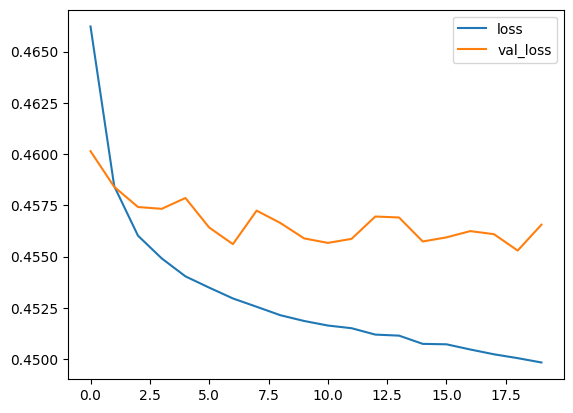

In [30]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

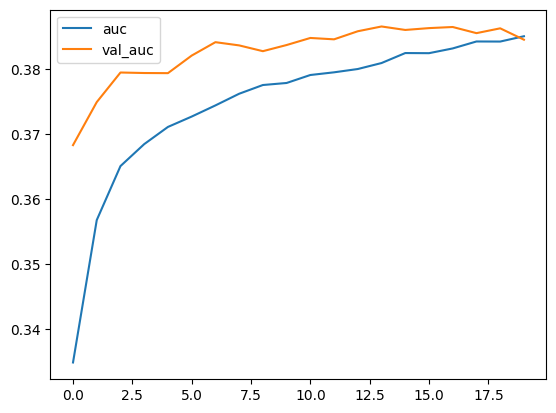

In [31]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

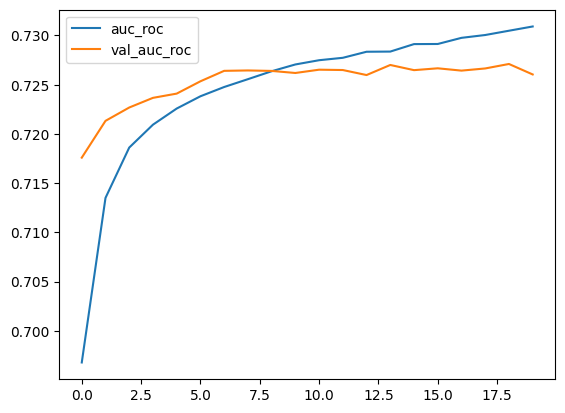

In [32]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [33]:
this_model.save(Path(setup.temp_path).joinpath('25_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [34]:
all_predictions = this_model.predict([X.drop(columns='dset'), 
                                      X_naics.drop(columns='dset')])

   98/21503 [..............................] - ETA: 33s

2024-04-08 11:02:23.153419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 84s 4ms/step


In [35]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(business_data[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [36]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.327163
target,0.327163,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [37]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [38]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [39]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
11,0.22,0.458800
12,0.24,0.458128
10,0.20,0.456673


In [40]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.22

##### Append binary predictions to probability predictions

In [41]:
all_predictions_df['predict_bin'] = sg_plot.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [42]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.569641
1    0.430359
Name: proportion, dtype: float64

In [43]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('25_DATA_predictions.parquet'))

## Metrics

In [44]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('25_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.647176,0.438374,0.318474,0.703067,0.367152,0.728074,NaN
1,train,0.656723,0.458800,0.338674,0.710982,0.397626,0.738958,NaN
2,val,0.649742,0.450853,0.334112,0.692986,0.384538,0.726052,NaN
0,test,0.650869,0.451593,0.333573,0.698850,0.381034,0.727966,0.0
1,test,0.641871,0.418752,0.296957,0.709923,0.343123,0.727708,1.0


## Embeddings
Get the NAICS embeddings for all codes

In [45]:
#this_model = keras.models.load_model(Path(setup.temp_path).joinpath('25_DATA_model.keras'))

In [46]:
embed_layer_name = 'naics_reshape'
#embed_layer_name = 'reshape_4'

In [47]:
unique_naics_x = business_data.drop_duplicates('NAICS_orig') \
    [['LoanNr_ChkDgt'] + numeric_features].set_index('LoanNr_ChkDgt').sort_index()

In [48]:
unique_naics_x.shape

(1311, 10)

In [49]:
unique_naics_x_naics = business_data.drop_duplicates('NAICS_orig')[['LoanNr_ChkDgt', 'NAICS']] \
    .set_index('LoanNr_ChkDgt').sort_index()

In [50]:
embed_model = Model(inputs=this_model.inputs, outputs=this_model.get_layer(embed_layer_name).output) 

In [51]:
embed_out = embed_model.predict([unique_naics_x, unique_naics_x_naics])

41/41 [==============================] - 0s 875us/step


2024-04-08 11:04:06.707458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [52]:
embed_out.shape

(1311, 8)

In [53]:
embed_df = pd.DataFrame(embed_out, index=unique_naics_x.index) 
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df.reset_index(inplace=True)

In [54]:
embed_df = pd.DataFrame(embed_out, index=unique_naics_x.index)  
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df = embed_df.reset_index() \
    .merge(business_data[['LoanNr_ChkDgt', 'NAICS', 'NAICS_orig']], how='left', on='LoanNr_ChkDgt') \
    .drop(columns='LoanNr_ChkDgt')

In [55]:
embed_df.head(3)

,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,NAICS,NAICS_orig
0,0.720058,-0.519170,0.409407,0.175112,-0.000629,0.898163,0.617700,0.434311,1095.0,722410
1,1.427286,-1.779123,1.212681,0.405218,0.291517,1.934087,0.435628,1.120715,398.0,332721
2,0.536821,-0.637489,0.255909,0.151857,0.093758,0.563031,0.429567,0.376434,0.0,445299


In [56]:
embed_df.to_parquet(Path(setup.temp_path).joinpath('25_DATA_embeddings.parquet'))